In [1]:
import tensorflow as tf

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
import pathlib
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

228827136/228813984 [==============================] - 20s 0us/step
/Users/mac/.keras/datasets/flower_photos


In [5]:
for item in data_root.iterdir():
    print(item)

/Users/mac/.keras/datasets/flower_photos/roses
/Users/mac/.keras/datasets/flower_photos/sunflowers
/Users/mac/.keras/datasets/flower_photos/daisy
/Users/mac/.keras/datasets/flower_photos/dandelion
/Users/mac/.keras/datasets/flower_photos/tulips
/Users/mac/.keras/datasets/flower_photos/LICENSE.txt


In [6]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count


3670

In [7]:
all_image_paths[:10]

['/Users/mac/.keras/datasets/flower_photos/sunflowers/18097401209_910a46fae1_n.jpg',
 '/Users/mac/.keras/datasets/flower_photos/daisy/5109508979_68e3530791_m.jpg',
 '/Users/mac/.keras/datasets/flower_photos/daisy/18635898912_eb8e058ef0.jpg',
 '/Users/mac/.keras/datasets/flower_photos/dandelion/7015947703_11b30c20c9_n.jpg',
 '/Users/mac/.keras/datasets/flower_photos/dandelion/2319777940_0cc5476b0d_n.jpg',
 '/Users/mac/.keras/datasets/flower_photos/dandelion/3730618647_5725c692c3_m.jpg',
 '/Users/mac/.keras/datasets/flower_photos/dandelion/3475811950_0fb89845f5_n.jpg',
 '/Users/mac/.keras/datasets/flower_photos/daisy/8964198962_6d8593b533.jpg',
 '/Users/mac/.keras/datasets/flower_photos/daisy/2057816617_18448093d0_n.jpg',
 '/Users/mac/.keras/datasets/flower_photos/dandelion/5681951567_d3b03bfd2a_m.jpg']

In [8]:
import os
attributions = (data_root/"LICENSE.txt").open(encoding='utf-8').readlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)

In [9]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])

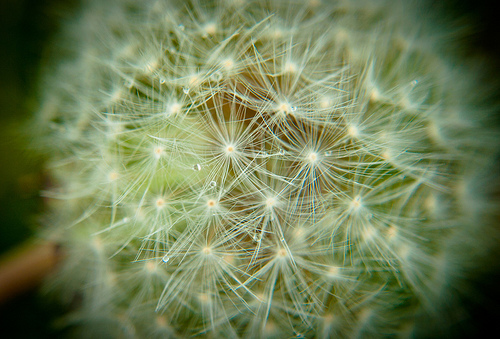

Image (CC BY 2.0)  by Holly Victoria Norval



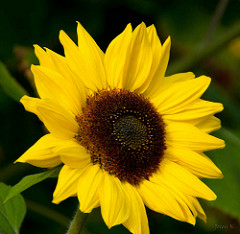

Image (CC BY 2.0)  by Jocelyn Kinghorn



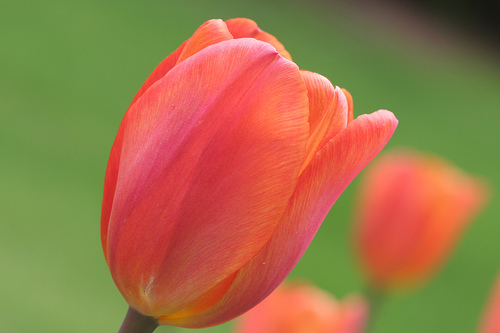

Image (CC BY 2.0)  by Sharon Mollerus



In [10]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print(caption_image(image_path))
  print()

In [11]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [12]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [13]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [3, 0, 0, 1, 1, 1, 1, 0, 0, 1]


In [14]:
img_path = all_image_paths[0]
img_path

'/Users/mac/.keras/datasets/flower_photos/sunflowers/18097401209_910a46fae1_n.jpg'

In [15]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00...


2022-01-10 23:20:22.726894: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(240, 320, 3)
<dtype: 'uint8'>


In [17]:
img_final = tf.image.resize(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
1.0


In [18]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range

  return image

In [19]:
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

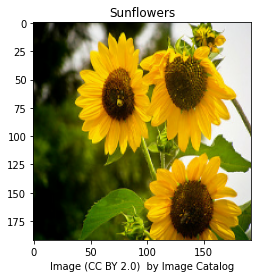

In [20]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())
print()

In [21]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)


In [22]:
print(path_ds)


<TensorSliceDataset shapes: (), types: tf.string>


In [23]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

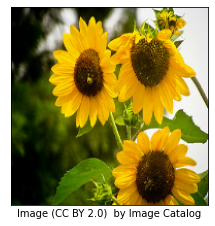

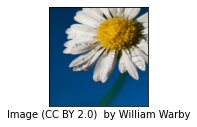

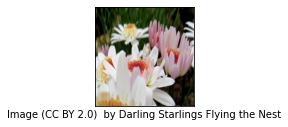

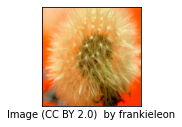

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(caption_image(all_image_paths[n]))
  plt.show()

In [25]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [26]:
for label in label_ds.take(10):
  print(label_names[label.numpy()])

sunflowers
daisy
daisy
dandelion
dandelion
dandelion
dandelion
daisy
daisy
dandelion


In [27]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [28]:
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>
